In [ ]:

import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM


# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# reading dataset
df = pd.read_csv("/content/drive/MyDrive/btc_price_data.csv")

In [ ]:
print('Total number of days present in the dataset: ',df.shape[0])
print('Total number of fields present in the dataset: ',df.shape[1])

Total number of days present in the dataset:  366
Total number of fields present in the dataset:  7


In [ ]:
df.shape
df.head()
df.tail()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           366 non-null    object 
 1   btc_open       366 non-null    float64
 2   btc_high       366 non-null    float64
 3   btc_low        366 non-null    float64
 4   btc_close      366 non-null    float64
 5   btc_adj_close  366 non-null    float64
 6   btc_volume     366 non-null    float64
dtypes: float64(6), object(1)
memory usage: 20.1+ KB


btc_open      btc_high       btc_low     btc_close  btc_adj_close  \
count    366.000000    366.000000    366.000000    366.000000     366.000000   
mean   23094.502765  23531.977737  22614.373373  23064.700068   23064.700068   
std     5750.766620   5872.429557   5559.831246   5689.340889    5689.340889   
min    15782.300780  16253.047850  15599.046880  15787.284180   15787.284180   
25%    19326.514653  19636.722165  19025.690427  19325.394040   19325.394040   
50%    21528.958985  21803.812500  20959.862305  21531.104490   21531.104490   
75%    24738.201170  25228.042965  24302.009767  24719.875000   24719.875000   
max    41501.746090  42893.582030  40961.097660  41502.750000   41502.750000   

         btc_volume  
count  3.660000e+02  
mean   2.910441e+10  
std    1.294824e+10  
min    7.714767e+09  
25%    2.050629e+10  
50%    2.725619e+10  
75%    3.410379e+10  
max    1.190000e+11

In [ ]:
print('Null Values:',df.isnull().values.sum())

Null Values: 0


In [ ]:
print('NA values:',df.isnull().values.any())

NA values: False


In [ ]:
df.shape

(366, 7)

In [ ]:
sd=df.iloc[0][0]
ed=df.iloc[-1][0]


print('Starting Date',sd)
print('Ending Date',ed)

Starting Date 17-04-2022
Ending Date 17-04-2023


In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

y_2023 = df.loc[(df['Date'] >= '17-04-2022')
                     & (df['Date'] < '17-04-2023')]

y_2023.drop(y_2023[['btc_close','btc_volume']],axis=1)

<ipython-input-9-5237aaade22d>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  y_2023 = df.loc[(df['Date'] >= '17-04-2022')
<ipython-input-9-5237aaade22d>:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  & (df['Date'] < '17-04-2023')]


Date     btc_open     btc_high      btc_low  btc_adj_close
0   2022-04-17  40417.77734  40570.72656  39620.89453    39716.95313
1   2022-04-18  39721.20313  40986.32031  38696.19141    40826.21484
2   2022-04-19  40828.17578  41672.96094  40618.63281    41502.75000
3   2022-04-20  41501.74609  42126.30078  40961.09766    41374.37891
4   2022-04-21  41371.51563  42893.58203  40063.82813    40527.36328
..         ...          ...          ...          ...            ...
360 2023-04-12  30231.58203  30462.48047  29725.57422    30139.05273
361 2023-04-13  29892.74023  30539.84570  29878.62305    30399.06641
362 2023-04-14  30409.56250  31005.60742  30044.49805    30485.69922
363 2023-04-15  30490.75000  30601.74023  30245.88281    30318.49609
364 2023-04-16  30315.97656  30555.53711  30157.83203    30315.35547

[365 rows x 5 columns]

In [ ]:
monthvise= y_2023.groupby(y_2023['Date'].dt.strftime('%B'))[['btc_open','btc_close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

btc_open     btc_close
Date                                 
January    20043.860132  20250.717490
February   23304.086008  23304.539203
March      24945.340412  25116.900895
April      34058.075456  34036.753841
May        31900.711128  31706.105218
June       24783.338477  24383.685483
July       21424.733053  21539.253843
August     22471.866558  22366.266318
September  19821.353711  19804.779231
October    19616.090285  19650.525643
November   17711.480599  17600.814323
December   16969.578819  16949.608809

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['btc_open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['btc_close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [ ]:
y_2023.groupby(y_2023['Date'].dt.strftime('%B'))['btc_low'].min()
monthvise_high = y_2023.groupby(df['Date'].dt.strftime('%B'))['btc_high'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2023.groupby(y_2023['Date'].dt.strftime('%B'))['btc_low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group',
                  title=' Monthwise High and Low stock price')
fig.show()

In [ ]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2023, x=y_2023.Date, y=[y_2023['btc_open'], y_2023['btc_close'],
                                          y_2023['btc_high'], y_2023['btc_low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [ ]:
# Lets First Take all the Close Price
closedf = df[['Date','btc_close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (366, 2)


In [ ]:
fig = px.line(closedf, x=closedf.Date, y=closedf.btc_close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Whole period of timeframe of Bitcoin close price 2022-2023', plot_bgcolor='white',
                  font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
# deleting date column and normalizing using MinMax Scaler

del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(366, 1)


In [ ]:
training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (219, 1)
test_data:  (147, 1)


In [ ]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (203, 15)
y_train:  (203,)
X_test:  (131, 15)
y_test (131,)


In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (203, 15, 1)
X_test:  (131, 15, 1)


In [ ]:
model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
7/7 [==============================] - 2s 62ms/step - loss: 0.0291 - val_loss: 0.0266
Epoch 2/200
7/7 [==============================] - 0s 13ms/step - loss: 0.0189 - val_loss: 0.0177
Epoch 3/200
7/7 [==============================] - 0s 13ms/step - loss: 0.0104 - val_loss: 0.0105
Epoch 4/200
7/7 [==============================] - 0s 13ms/step - loss: 0.0053 - val_loss: 0.0058
Epoch 5/200
7/7 [==============================] - 0s 15ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 6/200
7/7 [==============================] - 0s 16ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 7/200
7/7 [==============================] - 0s 13ms/step - loss: 0.0032 - val_loss: 0.0039
Epoch 8/200
7/7 [==============================] - 0s 13ms/step - loss: 0.0028 - val_loss: 0.0045
Epoch 9/200
7/7 [==============================] - 0s 14ms/step - loss: 0.0029 - val_loss: 0.0042
Epoch 10/200
7/7 [==============================] - 0s 13ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 11/200
7/7 [=

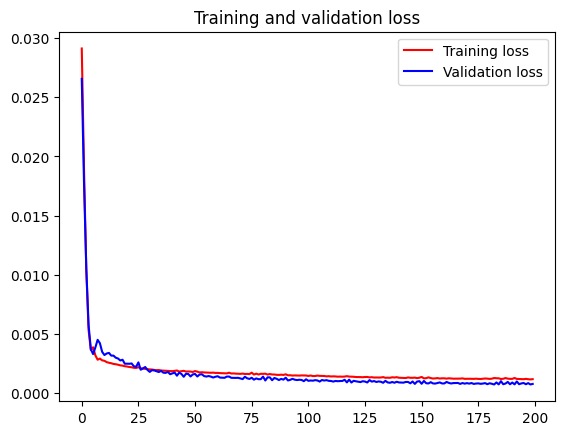

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

5/5 [==============================] - 0s 3ms/step


((203, 1), (131, 1))

In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  877.8535718613359
Train data MSE:  770626.8936297056
Train data MAE:  602.649779258005
-------------------------------------------------------------------------------------
Test data RMSE:  717.4084891769978
Test data MSE:  514674.9403432225
Test data MAE:  488.2679509351143


In [ ]:
print("Train data explained variance regression score:",
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:",
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9656084700456639
Test data explained variance regression score: 0.9747006345992255


In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9656044229974895
Test data R2 score: 0.971209637447551


In [ ]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.0013944490194057692
Test data MGD:  0.0009874727432652652
----------------------------------------------------------------------
Train data MPD:  32.09257580961856
Test data MPD:  22.326979608860405


In [ ]:

close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  366


In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)

        lst_output.extend(yhat.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1


In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'close price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()